In [1]:
import time
import itertools
import numpy as np
# from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

from swim import LJ, simple_md3d

import gsd.hoomd

In [2]:
m = 4
spacing = 3.5
L = m * spacing
x_ref = np.linspace(-L/2, L/2, m, endpoint=False) + spacing/2
position = np.array(list(itertools.product(x_ref, repeat=3)))

num_particles = 64
init_x3d = position[:num_particles]
box=[L, L, L]

In [3]:
lj = LJ()
lj.param = {'epsilon':2.0,
            'sigma':1.0, 
            'r_cut': 3.0}

In [4]:
md = simple_md3d(seed=2392)
md.set_param(dt=0.01,
             kT=1.0, 
             damping=10.)
md.set_init_config(init_x3d=init_x3d,
                   init_v3d=None,
                   num_particles=num_particles,
                   box=box)
md.pe = lj

In [5]:
def generate_move(d, nsteps):
    """random move within a sphere with radius d."""
    size=(int(nsteps),num_particles,1)
    theta = _rng.uniform(0, 2*np.pi, size=size)
    phi = _rng.uniform(0, np.pi, size=size)
    r = d * np.cbrt(_rng.uniform(0, 1, size=size))
    
    x = r*np.sin(phi)*np.cos(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(phi)
    move = np.dstack((x, y, z))
    
    return move

In [6]:
def create_snapshot(i, x):
    global num_particles, traj, box

    N_particles = num_particles
    
    snapshot = gsd.hoomd.Frame()
    snapshot.particles.types = ['A']
    snapshot.particles.N = N_particles
    snapshot.particles.typeid = [0] * N_particles
    snapshot.particles.position = x
    
    d = 1.0
    snapshot.particles.diameter = [d] * N_particles
    snapshot.configuration.box = [box[0], box[1], box[2], 0, 0, 0]
    snapshot.configuration.step = i
    
    return snapshot

f = gsd.hoomd.open(name='./mc3d_traj.gsd', mode='w')

In [7]:
start = time.time()

traj = [[0, init_x3d]]

counter = [0, 0]
_rng = np.random.default_rng(123)

nsteps=1e5
dump_stride = 1000
# uniform
rand_number = _rng.uniform(size=int(nsteps))
# 3-dim random move
move = generate_move(0.05, nsteps)

for i in range(int(nsteps)):
    
    # current
    _, current_x = traj[-1]
    nlist = md.nlist_search(current_x, rcut=lj.param['r_cut'], full=False)
    current_U = md.compute_pe(current_x, nlist)

    # try a move
    trial_x = current_x + move[i]

    # trial
    trial_x = md.pbc(trial_x, box)
    nlist = md.nlist_search(trial_x, rcut=lj.param['r_cut'], full=False)
    trial_U = md.compute_pe(trial_x, nlist)

    # Metropolis check
    dU = trial_U - current_U
    prob = np.exp(-dU) # kT=1
    if rand_number[i] < prob:
        # move was accepted
        counter[0] += 1
        inst_x = trial_x
    else:
        # move was rejected
        counter[1] += 1
        inst_x = current_x
    
    traj.append([i, inst_x])
    if i%dump_stride==0:
        snapshot = create_snapshot(i, inst_x)
        f.append(snapshot)
        f.flush()

print(time.time()-start, 's')

12.655107736587524 s


In [8]:
counter

[33681, 66319]

In [9]:
counter[0]/np.sum(counter)

0.33681

In [10]:
import freud

def compute_int_num_liq(snapshot):
    """
    Contiuous number of liquids
    """
    r_cut = 2.0
    box = snapshot.configuration.box
    points = snapshot.particles.position

    system = freud.AABBQuery(box, points)
    args = {"num_neighbors": 20, "exclude_ii": True}
    nlist = system.query(points, args).toNeighborList()
    d = nlist.distances.reshape(20,-1)
    coord_n = np.sum(1*(d<r_cut), axis=0)
    num_liq = np.sum(1*(coord_n>5))

    return num_liq

In [11]:
f = gsd.hoomd.open('./mc3d_traj.gsd', 'r')

In [12]:
n_arr = []
for frame in f:
    n = compute_int_num_liq(frame)
    n_arr.append(n)

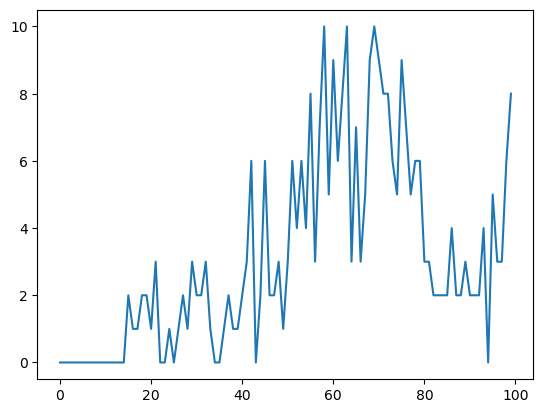

In [13]:
plt.plot(n_arr)